In [ ]:
!pip install transformers seqeval[gpu]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=2e4b6440b04c855ea361a39dc5fc645919c0bceb9762a61016a1c409d1d74b94
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
!pip install datasets seqeval torch scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from datasets import Dataset
from seqeval.metrics import classification_report

In [ ]:
ner_labels = ["O", "B-LANG", "B-FRAME", "B-LIB", "B-TOOL"]

In [ ]:
# 기술 요소 데이터 로드
technical_df = pd.read_csv("/content/technical_element.csv", encoding="utf-8-sig")

# 🔹 기술 요소 데이터를 기반으로 NER 라벨 매핑
# name, synonym 컬럼이 존재한다고 가정하고 처리
ner_mapping = {
    "language": "B-LANG",
    "framework": "B-FRAME",
    "library": "B-LIB",
    "tool": "B-TOOL"
}

# 새로운 컬럼 추가 (NER 태그 생성)
technical_df["ner_label"] = technical_df["category"].map(ner_mapping)

# 🔹 저장
OUTPUT_TECHNICAL_CSV = "/content/technical_element_labeled.csv"
technical_df.to_csv(OUTPUT_TECHNICAL_CSV, index=False, encoding="utf-8-sig")

print(f"✅ 기술 요소 NER 라벨링 완료! 파일 저장: {OUTPUT_TECHNICAL_CSV}")


✅ 기술 요소 NER 라벨링 완료! 파일 저장: /content/technical_element_labeled.csv


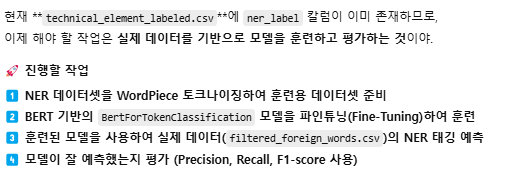

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForTokenClassification, Trainer, TrainingArguments
from datasets import Dataset
from seqeval.metrics import classification_report

# 🔹 NER 데이터 경로 설정 (Google Drive에서 가져오기)
NER_TRAIN_DATA = "/content/technical_element_labeled.csv"

# 🔹 데이터 불러오기
df = pd.read_csv(NER_TRAIN_DATA, encoding="utf-8-sig")

# 🔹 Hugging Face 사전 학습 모델 불러오기
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# 🔹 NER 태그 정의
ner_labels = ["O", "B-LANG", "B-FRAME", "B-LIB", "B-TOOL"]
label_map = {label: idx for idx, label in enumerate(ner_labels)}

# 🔹 데이터 전처리 함수 (토큰화 + NER 라벨 인코딩)
def preprocess_data(examples):
    tokens = examples["wordpiece_tokens"].split()
    labels = examples["ner_labels"].split()

    # ✅ 토큰화를 실행하고 padding & truncation 적용
    inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=512
    )

    # ✅ 실제 토큰 길이 가져오기
    input_length = len(inputs["input_ids"])

    # ✅ labels의 길이를 input_ids와 동일하도록 설정
    label_ids = [label_map.get(label, label_map["O"]) for label in labels]
    label_ids += [label_map["O"]] * (input_length - len(label_ids))
    label_ids = label_ids[:input_length]  # 최대 input_length까지만 유지

    # ✅ inputs에 labels 추가
    inputs["labels"] = label_ids

    return inputs

# 🔹 Hugging Face Dataset 변환
dataset = Dataset.from_pandas(df)
dataset = dataset.map(preprocess_data)

# 🔹 훈련 & 평가 데이터 분할
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset, eval_dataset = train_test_split["train"], train_test_split["test"]


 Step 1. WordPiece 토크나이징 및 훈련 데이터 준비

In [ ]:
import pandas as pd
from transformers import BertTokenizer

# 🔹 파일 경로 설정
TRAIN_DATA_PATH = "/content/technical_element_labeled.csv"
OUTPUT_TRAIN_PATH = "/content/ner_training_data.csv"

# 🔹 BERT 토크나이저 로드
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# 🔹 데이터 로드
df = pd.read_csv(TRAIN_DATA_PATH, encoding="utf-8-sig")

# 🔹 WordPiece 토큰화 및 NER 라벨 적용
wordpiece_tokens_list = []
ner_labels_list = []

for _, row in df.iterrows():
    words = [row["name"].lower()]  # name 컬럼 (기본 단어)
    if pd.notna(row["synonym"]):  # Synonym이 있으면 추가
        words.extend([syn.strip().lower() for syn in row["synonym"].split(",")])

    for word in words:
        tokens = tokenizer.tokenize(word)  # WordPiece 토큰화
        ner_label = row["ner_label"]  # 이미 부여된 NER 라벨

        wordpiece_tokens_list.append(" ".join(tokens))
        ner_labels_list.append(" ".join([ner_label] * len(tokens)))  # 모든 워드피스에 동일한 라벨 적용

# 🔹 새로운 데이터프레임 생성
train_df = pd.DataFrame({
    "wordpiece_tokens": wordpiece_tokens_list,
    "ner_labels": ner_labels_list
})

# 🔹 저장
train_df.to_csv(OUTPUT_TRAIN_PATH, index=False, encoding="utf-8-sig")


print(f"✅ WordPiece 기반 NER 훈련 데이터 생성 완료! 파일 저장: {OUTPUT_TRAIN_PATH}")


✅ WordPiece 기반 NER 훈련 데이터 생성 완료! 파일 저장: /content/ner_training_data.csv


Step 2. 모델 학습을 위한 데이터셋 변환

In [ ]:
import torch
from datasets import Dataset

# 🔹 NER 태그 정의
ner_labels = ["O", "B-LANG", "B-FRAME", "B-LIB", "B-TOOL"]
label_map = {label: idx for idx, label in enumerate(ner_labels)}

# 🔹 데이터 전처리 함수
def preprocess_data(examples):
    tokens = examples["wordpiece_tokens"].split()
    labels = examples["ner_labels"].split()

    # ✅ 토큰화를 실행하고 padding & truncation 적용
    inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=512
    )

    # ✅ 실제 토큰 길이 가져오기
    input_length = len(inputs["input_ids"])

    # ✅ labels의 길이를 input_ids와 동일하도록 설정
    label_ids = [label_map.get(label, label_map["O"]) for label in labels]
    label_ids += [label_map["O"]] * (input_length - len(label_ids))
    label_ids = label_ids[:input_length]

    inputs["labels"] = label_ids
    return inputs

# 🔹 Dataset 변환 및 전처리
dataset = Dataset.from_pandas(train_df)
dataset = dataset.map(preprocess_data)

# 🔹 훈련 & 평가 데이터 분할
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset, eval_dataset = train_test_split["train"], train_test_split["test"]


Map:   0%|          | 0/721 [00:00<?, ? examples/s]

Step 3. BERT 기반의 NER 모델 학습

In [ ]:
from transformers import BertForTokenClassification, Trainer, TrainingArguments

# 🔹 학습 파라미터 설정
training_args = TrainingArguments(
    output_dir="./ner_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10
)

# 🔹 BERT 모델 초기화 (NER 태그 개수 지정)
model = BertForTokenClassification.from_pretrained(model_name, num_labels=len(ner_labels))

# 🔹 Trainer 설정
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

# 🔹 모델 학습 시작
trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-26e43e8c183c>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cgygy8989 (cgygy8989-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,0.007500,0.006861
2,0.005300,0.006418
3,0.006100,0.005894


TrainOutput(global_step=432, training_loss=0.014307556854974892, metrics={'train_runtime': 314.8435, 'train_samples_per_second': 5.488, 'train_steps_per_second': 1.372, 'total_flos': 451533042155520.0, 'train_loss': 0.014307556854974892, 'epoch': 3.0})

Step 4. 학습된 모델을 사용하여 새로운 데이터 예측

In [ ]:
import torch

# 모델이 GPU에서 실행 중이면, GPU로 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [ ]:
# 🔹 실제 예측 수행을 위한 데이터 로드
PREDICT_DATA_PATH = "/content/filtered_foreign_words.csv"
foreign_df = pd.read_csv(PREDICT_DATA_PATH, encoding="utf-8-sig")

def predict_ner(text):
    tokens = tokenizer.tokenize(text)
    inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    predictions = torch.argmax(outputs.logits, dim=2)
    predicted_labels = [ner_labels[idx.item()] for idx in predictions[0]]

    return tokens, predicted_labels

# 🔹 모든 행에 대해 NER 예측 수행
foreign_df["tokens"], foreign_df["predicted_labels"] = zip(*foreign_df["foreign_only"].apply(predict_ner))

# 🔹 예측 결과 저장
OUTPUT_PREDICT_CSV = "/content/predicted_ner_results2.csv"
foreign_df.to_csv(OUTPUT_PREDICT_CSV, index=False, encoding="utf-8-sig")

print(f"✅ NER 예측 완료! 파일 저장: {OUTPUT_PREDICT_CSV}")

✅ NER 예측 완료! 파일 저장: /content/predicted_ner_results2.csv


Step 5. 평가 (Precision, Recall, F1-score 계산)

In [ ]:
import pandas as pd

# 🔹 파일 경로 설정
PREDICTED_CSV = "/content/predicted_ner_results2.csv"
TRUE_LABELS_CSV = "/content/technical_element_labeled.csv"

# 🔹 CSV 파일 로드
predicted_df = pd.read_csv(PREDICTED_CSV, encoding="utf-8-sig")
true_labels_df = pd.read_csv(TRUE_LABELS_CSV, encoding="utf-8-sig")

# 🔹 확인 (컬럼 확인)
print("🔹 모델 예측 데이터 컬럼:", predicted_df.columns)
print("🔹 정답 데이터 컬럼:", true_labels_df.columns)


🔹 모델 예측 데이터 컬럼: Index(['foreign_only', 'tokens', 'predicted_labels'], dtype='object')
🔹 정답 데이터 컬럼: Index(['seq', 'category', 'name', 'synonym', 'ner_label'], dtype='object')


정답(ner_label)을 예측 데이터(predicted_df)에 추가

In [ ]:
predicted_df에는 **모델이 예측한 predicted_labels**만 있음
true_labels_df의 name 또는 synonym과 매칭하여 정답(ner_label)을 추가

In [ ]:
# 🔹 기술 요소 데이터 매핑 (name & synonym → ner_label)
truth_dict = {}

for _, row in true_labels_df.iterrows():
    truth_dict[row["name"].lower()] = row["ner_label"]  # name 기반 정답 매핑
    if pd.notna(row["synonym"]):  # synonym도 정답 데이터에 포함
        for synonym in row["synonym"].split(","):
            truth_dict[synonym.strip().lower()] = row["ner_label"]

# 🔹 `predicted_df`에 정답(`true_ner_labels`) 추가
predicted_df["true_ner_labels"] = predicted_df["foreign_only"].apply(lambda x: truth_dict.get(x.lower(), "O"))

print("✅ `true_ner_labels` 컬럼 추가 완료! 이제 모델 예측 결과와 비교 가능.")


✅ `true_ner_labels` 컬럼 추가 완료! 이제 모델 예측 결과와 비교 가능.


In [ ]:
# 🔹 true_labels와 pred_labels를 리스트 형태로 변환하면서 BIO 태그 보정
true_labels = predicted_df["true_ner_labels"].apply(lambda x: x.split())
pred_labels = predicted_df["predicted_labels"].apply(lambda x: x.split())

# 🔹 BIO 형식 보정 함수
def fix_bio_labels(label_seq):
    fixed_labels = []
    prev_label = "O"

    for label in label_seq:
        if label == "O":
            fixed_labels.append("O")
        elif label.startswith("B-"):
            fixed_labels.append(label)
            prev_label = label
        else:
            if prev_label == "O":  # "I-" 태그가 첫 번째로 나올 경우 "B-"로 변경
                fixed_labels.append(label.replace("I-", "B-"))
            else:
                fixed_labels.append(label)
        prev_label = label

    return fixed_labels

# 🔹 BIO 태그 보정 적용
true_labels_fixed = true_labels.apply(fix_bio_labels)
pred_labels_fixed = pred_labels.apply(fix_bio_labels)

# 🔹 평가 수행
from seqeval.metrics import classification_report

report = classification_report(true_labels_fixed.tolist(), pred_labels_fixed.tolist(), digits=4)
print("🔹 NER 평가 결과:\n", report)


ValueError: Found input variables with inconsistent numbers of samples:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512]

In [ ]:
# 🔹 true_ner_labels와 predicted_labels가 서로 다른 길이를 가지는지 확인
true_labels = predicted_df["true_ner_labels"].apply(lambda x: x.split())
pred_labels = predicted_df["predicted_labels"].apply(lambda x: x.split())

print("✅ true_labels 길이:", len(true_labels))
print("✅ pred_labels 길이:", len(pred_labels))


✅ true_labels 길이: 3930
✅ pred_labels 길이: 3930


In [ ]:
def align_labels_to_predictions(true_label_str, predicted_label_list):
    true_label_tokens = true_label_str.split()

    # WordPiece 개수에 맞춰 정답 데이터를 확장
    expanded_true_labels = []
    true_index = 0

    for pred_token in predicted_label_list:
        if pred_token.startswith("##"):  # 워드피스 토큰이면 이전 라벨 유지
            expanded_true_labels.append(expanded_true_labels[-1])
        else:  # 새로운 단어면 정답에서 가져오기
            expanded_true_labels.append(true_label_tokens[true_index] if true_index < len(true_label_tokens) else "O")
            true_index += 1

    return expanded_true_labels

# 🔹 true_ner_labels을 predicted_labels에 맞춰 변환
predicted_df["aligned_true_labels"] = predicted_df.apply(
    lambda row: align_labels_to_predictions(row["true_ner_labels"], row["predicted_labels"].split()), axis=1
)

# 🔹 정답과 예측 라벨 변환
true_labels_fixed = predicted_df["aligned_true_labels"]
pred_labels_fixed = predicted_df["predicted_labels"].apply(lambda x: x.split())

print("✅ 정답 라벨 길이:", len(true_labels_fixed))
print("✅ 예측 라벨 길이:", len(pred_labels_fixed))


✅ 정답 라벨 길이: 3930
✅ 예측 라벨 길이: 3930


In [ ]:
from seqeval.metrics import classification_report

# 🔹 평가 수행
report = classification_report(true_labels_fixed.tolist(), pred_labels_fixed.tolist(), digits=4)
print("🔹 NER 평가 결과:\n", report)


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ['B-TOOL', seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 'B-TOOL', seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 'O', seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 'O'] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

🔹 NER 평가 결과:
               precision    recall  f1-score   support

        LANG     0.0000    0.0000    0.0000         3
         O',     0.0000    0.0000    0.0000         0
         O']     0.0000    0.0000    0.0000         0
      TOOL',     0.0000    0.0000    0.0000         0

   micro avg     0.0000    0.0000    0.0000         3
   macro avg     0.0000    0.0000    0.0000         3
weighted avg     0.0000    0.0000    0.0000         3



In [ ]:
print(predicted_df.head())
print("✅ 데이터 컬럼 확인:", predicted_df.columns)


                                        foreign_only  \
0  ai ai data camp ui mlops platform lisa look in...   
1              kisa spring framework spring boot jpa   
2  llm test code javascript typescript api django...   
3  a b mmm mta casual impact sql python bi tablea...   
4  emr electric medical record windows client wpf...   

                                              tokens  \
0  ['ai', 'ai', 'data', 'camp', 'u', '##i', 'ml',...   
1  ['kis', '##a', 'spring', 'framework', 'spring'...   
2  ['ll', '##m', 'test', 'code', 'ja', '##vas', '...   
3  ['a', 'b', 'mm', '##m', 'm', '##ta', 'casu', '...   
4  ['em', '##r', 'electric', 'medical', 'record',...   

                                    predicted_labels true_ner_labels  \
0  ['B-TOOL', 'B-TOOL', 'B-TOOL', 'B-TOOL', 'B-TO...               O   
1  ['B-TOOL', 'B-TOOL', 'B-TOOL', 'B-TOOL', 'B-TO...               O   
2  ['B-TOOL', 'B-TOOL', 'B-TOOL', 'B-TOOL', 'B-TO...               O   
3  ['B-TOOL', 'B-TOOL', 'B-TOOL', 'B-T

In [ ]:
# 🔹 문자열을 리스트로 변환
predicted_df["true_ner_labels"] = predicted_df["true_ner_labels"].apply(lambda x: x.strip("[]").replace("'", "").split())
predicted_df["predicted_labels"] = predicted_df["predicted_labels"].apply(lambda x: x.strip("[]").replace("'", "").split())

# 🔹 변환 후 데이터 확인
print(predicted_df.head())


                                        foreign_only  \
0  ai ai data camp ui mlops platform lisa look in...   
1              kisa spring framework spring boot jpa   
2  llm test code javascript typescript api django...   
3  a b mmm mta casual impact sql python bi tablea...   
4  emr electric medical record windows client wpf...   

                                              tokens  \
0  ['ai', 'ai', 'data', 'camp', 'u', '##i', 'ml',...   
1  ['kis', '##a', 'spring', 'framework', 'spring'...   
2  ['ll', '##m', 'test', 'code', 'ja', '##vas', '...   
3  ['a', 'b', 'mm', '##m', 'm', '##ta', 'casu', '...   
4  ['em', '##r', 'electric', 'medical', 'record',...   

                                    predicted_labels true_ner_labels  \
0  [B-TOOL,, B-TOOL,, B-TOOL,, B-TOOL,, B-TOOL,, ...             [O]   
1  [B-TOOL,, B-TOOL,, B-TOOL,, B-TOOL,, B-TOOL,, ...             [O]   
2  [B-TOOL,, B-TOOL,, B-TOOL,, B-TOOL,, B-TOOL,, ...             [O]   
3  [B-TOOL,, B-TOOL,, B-TOOL,, B-TOOL,

In [ ]:
from seqeval.metrics import classification_report

# 🔹 평가 수행
report = classification_report(predicted_df["true_ner_labels"].tolist(), predicted_df["predicted_labels"].tolist(), digits=4)
print("🔹 NER 평가 결과:\n", report)


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: O, seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


ValueError: Found input variables with inconsistent numbers of samples:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512]

In [ ]:
print("✅ true_labels 샘플:", predicted_df["true_ner_labels"].head().tolist())
print("✅ pred_labels 샘플:", predicted_df["predicted_labels"].head().tolist())


✅ true_labels 샘플: [['O'], ['O'], ['O'], ['O'], ['O']]
✅ pred_labels 샘플: [['B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'O,', 'B-TOOL,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'O,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'O,', 'O,', 'O,', 'O,', 'O,', 'B-TOOL,', 'O,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'B-TOOL,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', 'O,', '

In [ ]:
# 🔹 콤마(,) 제거 후 리스트로 변환
predicted_df["predicted_labels"] = predicted_df["predicted_labels"].apply(lambda x: [label.replace(",", "") for label in x])


In [ ]:
def align_labels_to_predictions(true_label_list, predicted_label_list):
    """
    WordPiece 단위로 변환된 predicted_labels에 맞춰 true_labels를 확장.
    """
    aligned_labels = []
    true_index = 0

    for pred_token in predicted_label_list:
        if pred_token.startswith("##"):  # WordPiece 조각이면 이전 라벨 유지
            aligned_labels.append(aligned_labels[-1])
        else:  # 새 단어라면 true_labels에서 가져오기
            aligned_labels.append(true_label_list[true_index] if true_index < len(true_label_list) else "O")
            true_index += 1

    return aligned_labels

# 🔹 정답 라벨 길이 보정
predicted_df["aligned_true_labels"] = predicted_df.apply(
    lambda row: align_labels_to_predictions(row["true_ner_labels"], row["predicted_labels"]), axis=1
)

# 🔹 변환 후 길이 확인
print("✅ true_labels (보정 후) 길이:", predicted_df["aligned_true_labels"].apply(len).tolist())
print("✅ pred_labels 길이:", predicted_df["predicted_labels"].apply(len).tolist())


✅ true_labels (보정 후) 길이: [512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512,

In [ ]:
from seqeval.metrics import classification_report

# 🔹 평가 수행
report = classification_report(predicted_df["aligned_true_labels"].tolist(), predicted_df["predicted_labels"].tolist(), digits=4)
print("🔹 NER 평가 결과:\n", report)


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


🔹 NER 평가 결과:
               precision    recall  f1-score   support

        LANG     0.0000    0.0000    0.0000         3
        TOOL     0.0000    0.0000    0.0000         0

   micro avg     0.0000    0.0000    0.0000         3
   macro avg     0.0000    0.0000    0.0000         3
weighted avg     0.0000    0.0000    0.0000         3



In [ ]:
# 🔹 샘플 10개 확인
print("✅ 정답 라벨 샘플:\n", predicted_df["aligned_true_labels"].head(10).tolist())
print("✅ 모델 예측 라벨 샘플:\n", predicted_df["predicted_labels"].head(10).tolist())


✅ 정답 라벨 샘플:
 [['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 